# 0.0 IMPORTS, FUNCTIONS AND CONNECTIONS

## 0.1 PACKAGES AND LIBRARIES

In [1]:
import pandas as pd
import psycopg2 as pg
import seaborn as sns
import warnings
import dotenv
import os

from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from IPython.core.display import HTML
from IPython.display import Image

## 0.2 Helper Function

In [2]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Connections

In [4]:
dotenv.load_dotenv(dotenv.find_dotenv())
url_sql = os.getenv('url_sql')

engine = create_engine(url_sql)

In [5]:
sql_query = '''
SELECT u.id, u.age, u.region_code, u.policy_sales_channel,
       i.previously_insured, i.annual_premium, i.vintage, i.response,
       v.driving_license, v.vehicle_age, v.vehicle_damage
       FROM pa004.users u LEFT JOIN pa004.insurance i ON (u.id = i.id)
                          LEFT JOIN pa004.vehicle v  ON (u.id = v.id)                   
                          '''

df_raw = pd.read_sql_query(sql_query, con=engine)

In [6]:
df_raw.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Rows: {df1.shape[1]}')

Number of Rows: 381109
Number of Rows: 11


## 1.2 Changing Data Types

In [9]:
df1.dtypes

id                        int64
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

In [10]:
df1['region_code'] = df1['region_code'].astype(int64)

df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int64)

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

## 1.3 Check NA

In [11]:
df1.isna().sum()

id                      0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Numerical Data Description

In [12]:
# Data Selection
df1_num = df1.select_dtypes(include=['int64', 'float64'])

#Central Tendency
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion 
d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_descript = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T
df_descript.columns = ['min','max', 'range', 'average', 'median', 'std', 'skew', 'kurtosis']
df_descript

,min,max,range,average,median,std,skew,kurtosis
id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630


## 1.5 Categorical Data Description

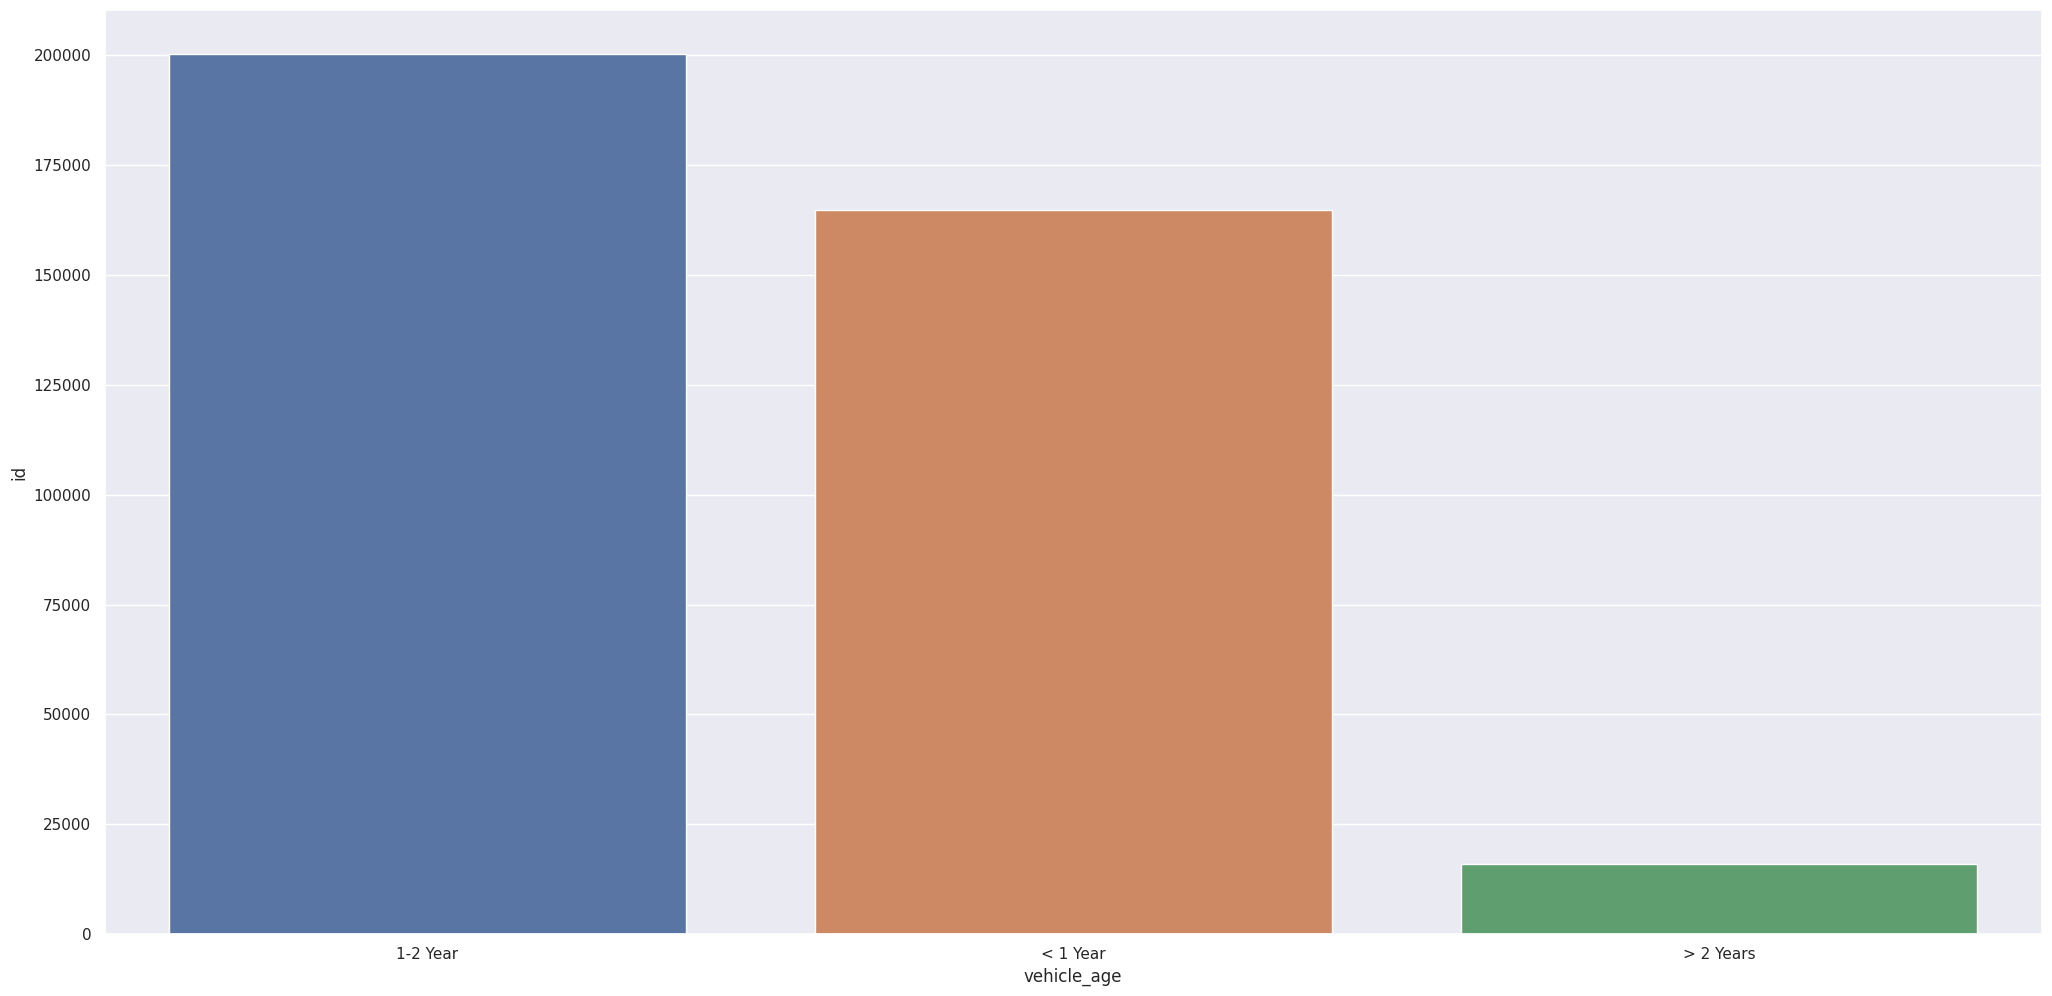

In [13]:
df_cat = df1[['vehicle_age', 'id']].groupby('vehicle_age').count().reset_index()

sns.barplot(data=df_cat, x='vehicle_age', y='id');

# 2.0 FEATURE ENGINEERING

In [14]:
df2 = df1.copy()
reorder_columns = ['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'response']

df2 = df2.reindex(columns=reorder_columns)

## 2.1 Hypothesis Mindmap

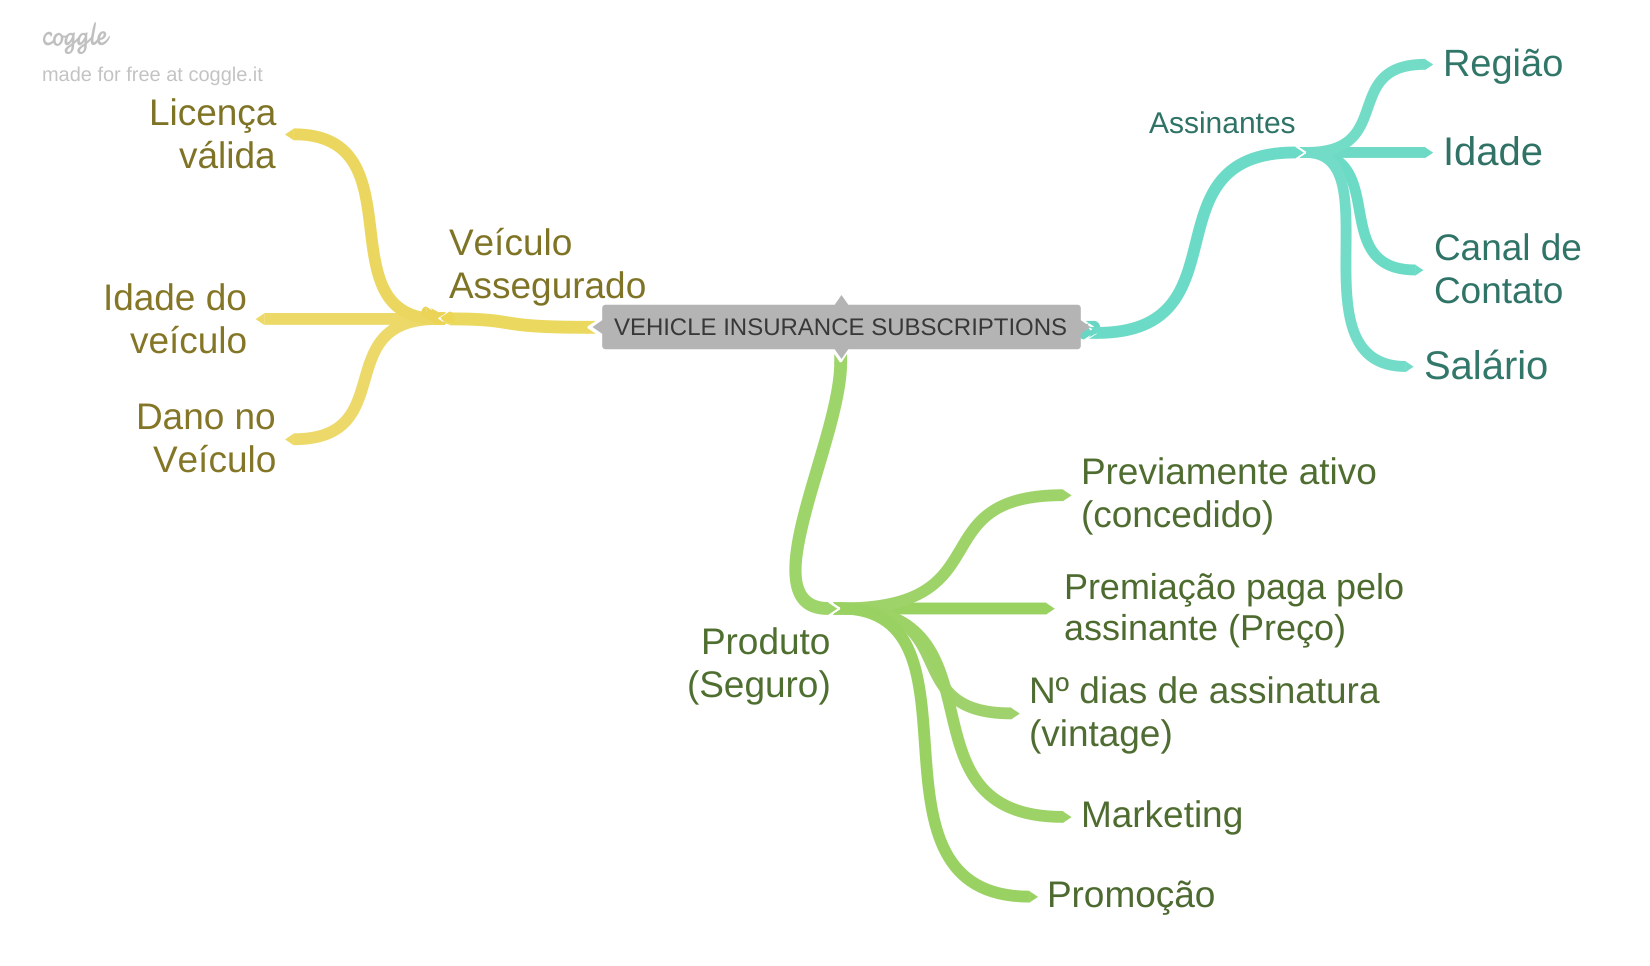

In [15]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses de Assinantes

1. Quanto maior a idade, maior propensão do cliente adquirir um plano seguro de saúde.
2. Quanto maior o salário, maior a propensão do cliente a adquirir um plano de seguro de saúde.
3. Quanto mais próx a um centro urbano(região), maior a propensão do cliente adquirir um plano de seguro de saúde.
    *Há alguma região com maior compra de aquisição de seguros?

### 2.2.2 Hipótese do Produto (Assinatura de seguro veícular)

1. Clientes que já ativaram o seguro veícular possuem maior propensão a adquirir um plano de saúde.
2. Clientes que pagam mais caro pela assinatura possuem menor propensão a adquirir um plano de saúde.
3. Clientes com mais dias de assinatura possuem maior propensão a adquirir um plano de saúde.
4. Clientes ficam mais propensos a assinar um plano de saúde conjunto após a realização de campanhas de marketing.
5. Clientes ficam mais propensos a assinar um plano de saúde com a realização de promoção conjunta ao plano de seguro veícular.

### 2.2.3 Hipóteses do Veículo em Seguridade

1. Clientes com a licença de habilitação são mais propensos a adquirir um plano de seguro de saúde.
2. Clientes com veículos mais antigos são mais propensos a adquirir um plano de seguro de saúde.
3. Clientes com veículos já danificados são mais propensos a adquirir um plano de seguro de saúde.

## 2.3 Hipóteses Selecionadas

1. Quanto maior a idade, maior propensão do cliente adquirir um plano seguro veícular.

2. Clientes que já ativaram/possuem o seguro hospitalar possuem maior propensão a adquirir um plano de seguro veícular.
3. Clientes que pagam mais caro pela assinatura possuem menor propensão a adquirir um plano de seguro veícular.
4. Clientes com mais dias de assinatura possuem maior propensão a adquirir um plano de seguro veícular.

5. Clientes com licença de habilitação são mais propensos a adquirir um plano de seguro veícular.
6. Clientes com veículos mais antigos são mais propensos a adquirir um plano de seguro veícular.
7. Clientes com veículos já danificados são mais propensos a adquirir um plano de seguro veícular.

In [16]:
df2.head()

,id,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,23,11,152,0,23367.0,249,1,< 1 Year,1,0
1,13,41,15,14,1,31409.0,221,1,1-2 Year,0,0
2,18,25,35,152,1,46622.0,299,1,< 1 Year,0,0
3,31,26,8,160,0,2630.0,136,1,< 1 Year,0,0
4,39,45,8,124,0,42297.0,264,1,1-2 Year,1,0


# 3.0 Exploratory Data Analysis

In [17]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Variável Numérica

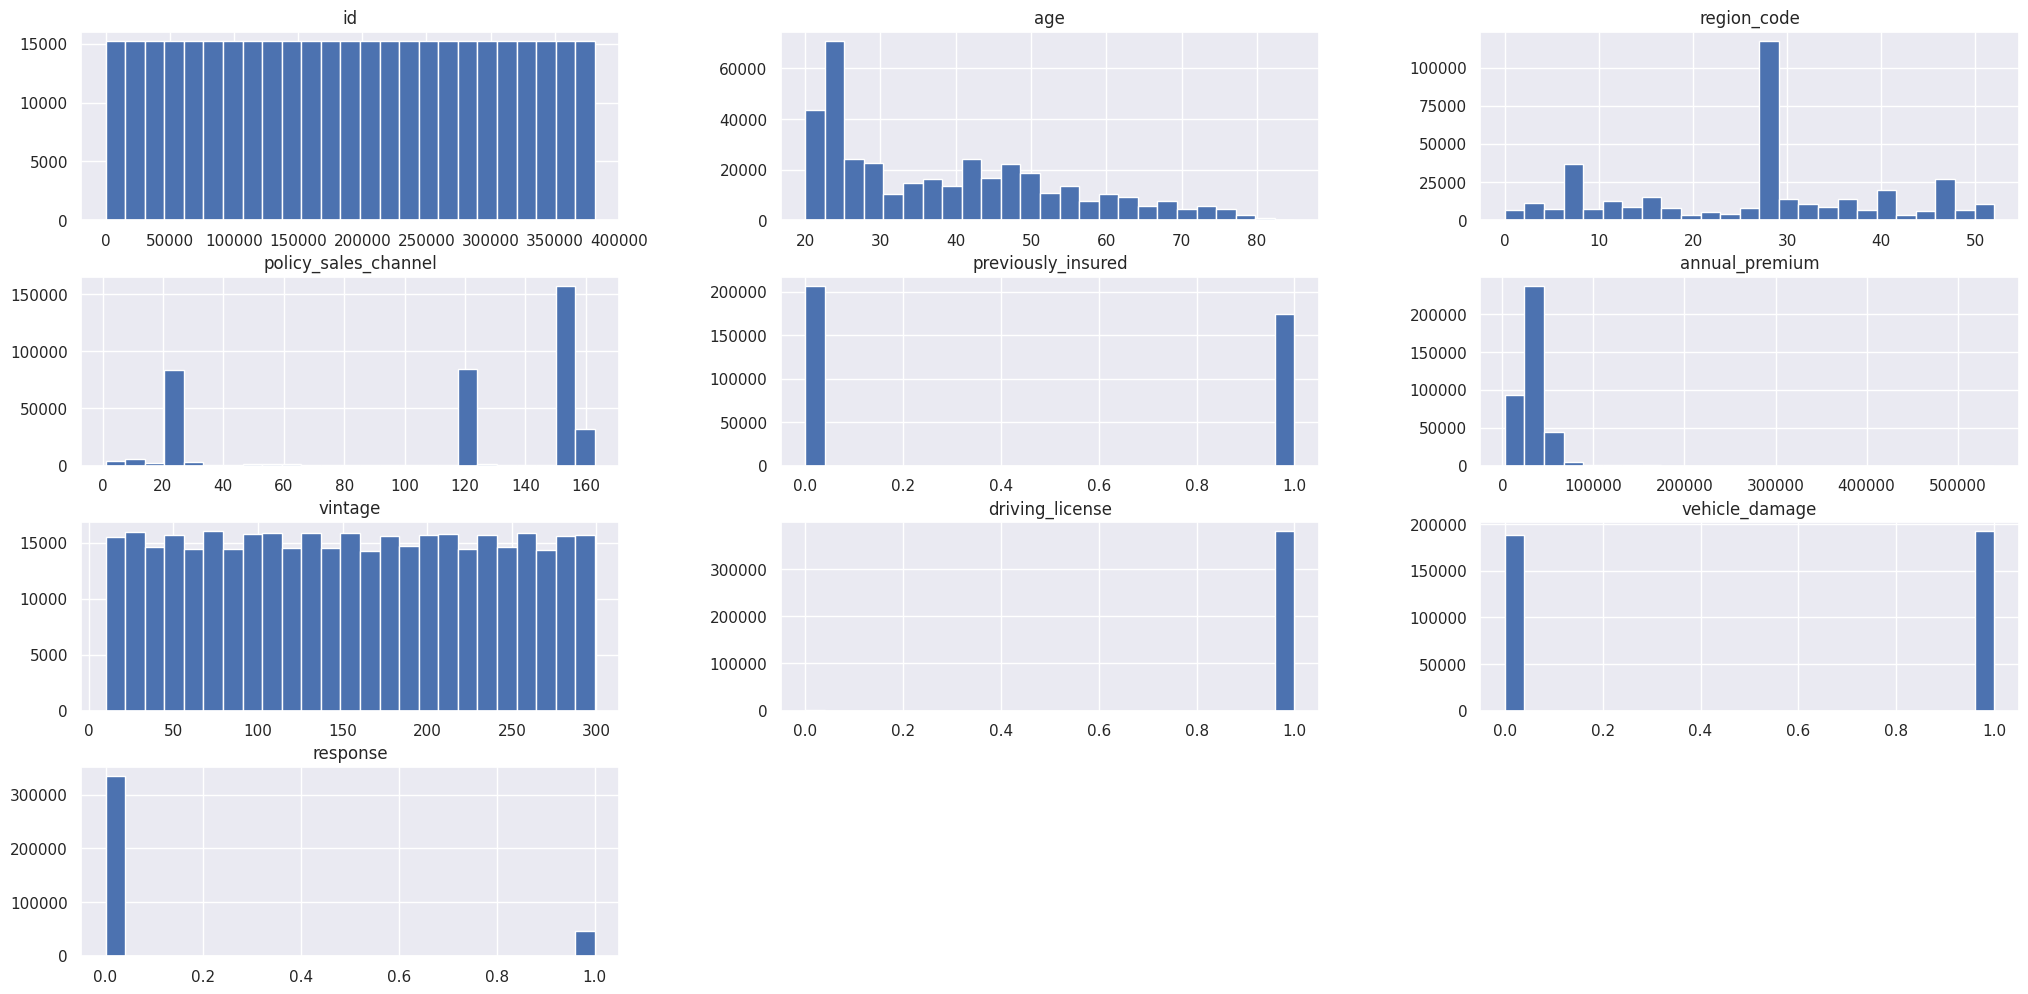

In [18]:
df3_num = df3.select_dtypes(include=['int64', 'float64'])

df3_num.hist(bins=25);

### 3.1.2 Variável Categórica

In [19]:
df3['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object